#l Online Augmentation + ResNet50 Training Computer Vision Proyecto Final

This collab notebook is built so that it can be ran accross sessions. The checkpoints and how to run them for the two training phases of the model (head and fine tuning) are specified in each step below.

**How to actually run this across multiple sessions (summary)**

Scenario: Colab disconnects after some hours.

- When you reconnect, always start from the top:

  - Step 1: mount Drive, set WORK_DIR

  - Step 2–4: load CSV, build generators, class weights

- For Phase 1 (at least one epoch has to have finished in order to have a checkpoint to be loaded):

  - Run Step 6: it will detect resnet50_phase1_best.keras and load it.

  - Run Step 7 again to train more epochs.

- When Phase 1 is good, move to Phase 2:

  - Run Step 8 to load Phase 1 best, unfreeze top layers, compile.

  - Run Step 9 in blocks of 5 epochs.

- If you disconnect during Phase 2:

  - Reconnect, rerun up to Step 8, but modify the load logic to prefer phase2_ckpt_path if it exists.

  - Then run Step 9 to continue.

As long as you never delete the checkpoints_resnet50_online folder in Drive, you will always be able to resume from the last best model.

### Step 1 – Mount Drive & Set Paths

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import tensorflow as tf

# Base working directory (shared by all experiments)
WORK_DIR = '/content/drive/MyDrive/Colab Notebooks/ComputerVision'

#  Name of this specific experiment (AUGMENTED RESNET)
EXP_NAME = 'resnet50_with_aug_v2'   # <-- change this to make another variant

#  Experiment directory: everything for this training goes here
EXP_DIR = os.path.join(WORK_DIR, 'experiments', EXP_NAME)
os.makedirs(EXP_DIR, exist_ok=True)

# Path to the CSV with original images and labels (shared across experiments)
CSV_PATH = os.path.join(WORK_DIR, 'image_labels.csv')

print("WORK_DIR:", WORK_DIR)
print("CSV_PATH:", CSV_PATH)
print("EXP_NAME:", EXP_NAME)
print("EXP_DIR :", EXP_DIR)

Mounted at /content/drive
WORK_DIR: /content/drive/MyDrive/Colab Notebooks/ComputerVision
CSV_PATH: /content/drive/MyDrive/Colab Notebooks/ComputerVision/image_labels.csv
EXP_NAME: resnet50_with_aug_v2
EXP_DIR : /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2


####Step 1.1 **Copy Raw Dataset to Local Disk + Rewrite Paths**
TO make training faster we we going to copy our dataset from drive into our fast local storage so we use local images and we dont need to go fetch each time into drive which creates a bottleneck.



In [2]:
# ------------------------------------------------------------
# SPEEDUP BLOCK COPY DATASET TO LOCAL DISK (/content)
# ------------------------------------------------------------
# ------------------------------------------------------------
# SUPER-FAST LOAD BLOCK to unzip dataset to local VM storage
# ------------------------------------------------------------
import os
import pandas as pd

LOCAL_RAW_DATA_DIR = "/content/Dataset_Consolidado_LOCAL"

# UPDATE THIS TO MATCH YOUR ZIP FILE NAME EXACTLY
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Dataset Consolidado.zip"

# 1. Unzip to /content if not already there (new runtime = empty)
if not os.path.exists(LOCAL_RAW_DATA_DIR):
    print("Unzipping dataset to local VM storage...")
    !unzip -q "$ZIP_PATH" -d /content/
    # After unzip, Drive folder name may be "Dataset Consolidado"
    !mv "/content/Dataset Consolidado" "$LOCAL_RAW_DATA_DIR"
    print("Unzip complete.")
else:
    print("Local dataset already exists — fast mode enabled.")

# ------------------------------------------------------------
# 2. Load CSV and rewrite 'image_path' to use local dataset
# ------------------------------------------------------------

df_all = pd.read_csv(CSV_PATH)

RAW_DATA_DIR = os.path.join(WORK_DIR, 'Dataset Consolidado')

def convert_drive_to_local(path):
    return path.replace(RAW_DATA_DIR, LOCAL_RAW_DATA_DIR)

df_all['image_path'] = df_all['image_path'].apply(convert_drive_to_local)

print("Example converted path:")
print(df_all.iloc[0]['image_path'])



Unzipping dataset to local VM storage...
Unzip complete.
Example converted path:
/content/Dataset_Consolidado_LOCAL/Papel y Carton/paper_2091.jpg


### Step 2 – Load Original Dataset & Train/Val Split

We have some broken images in our files that are messing with the training, in the commented check we:

-Find and remove the broken images from the CSV
- clean it
- redo df_all

Unfortunately no images had issues with the simple check done here. This check took 4 hours and we do not have computation power to do the full checks with the same transformations keras uses when it encounters errors.

In short:

Note on Dataset Integrity Check and Truncated Images:

We performed a full dataset integrity scan by iterating through all image files and running PIL.Image.verify() on each. This method performs only a lightweight header validation and does not fully decode or resize the image. Because the corruption in our dataset only triggers errors during full image loading and resizing, the verification step reported 0 bad images, even though training later failed with a “truncated image” error.

 Instead of performing a much slower deep scan (which would require fully decoding all ~60k images), we adopted the quick unblock approach by enabling ImageFile.LOAD_TRUNCATED_IMAGES = True before creating the ImageDataGenerators. This instructs PIL to tolerate partially corrupted or truncated images during training. With this setting applied, training continues smoothly without crashing, while the remaining image data is still used as effectively as possible.


In [ ]:
#from PIL import Image
#import tqdm

#bad_indices = []

#for i, row in tqdm.tqdm(df_all.iterrows(), total=len(df_all)):
#    path = row["image_path"]
#    try:
#        with Image.open(path) as img:
#            img.verify()  # cheap check
#    except Exception as e:
#        print(f"Bad image at index {i}, path={path}, error={e}")
#        bad_indices.append(i)

#print("Total bad images:", len(bad_indices))

# Drop them
#df_clean = df_all.drop(index=bad_indices).reset_index(drop=True)

# Then redo the split using df_clean instead of df_all
#df_all = df_clean  # replace full dataframe with cleaned one
# ... stratified split code as before ...




In [3]:
# Load the full list of images and labels
df_all = pd.read_csv(CSV_PATH)
print("Total images:", len(df_all))
df_all.head()

SEED = 42

# Fractions for the three-way split
TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1

rng = np.random.default_rng(SEED)

train_idx = []
val_idx   = []
test_idx  = []

# Stratified split per label
for label, group in df_all.groupby('label', sort=False):
    idx = group.index.to_numpy()
    rng.shuffle(idx)
    n_total = len(idx)

    n_train = int(n_total * TRAIN_FRAC)
    n_val   = int(n_total * VAL_FRAC)
    n_test  = n_total - n_train - n_val  # remaining

    train_idx.extend(idx[:n_train])
    val_idx.extend(idx[n_train:n_train + n_val])
    test_idx.extend(idx[n_train + n_val:])

df_train_orig = df_all.loc[train_idx].reset_index(drop=True)
df_val_orig   = df_all.loc[val_idx].reset_index(drop=True)
df_test_orig  = df_all.loc[test_idx].reset_index(drop=True)

print("Train originals:", len(df_train_orig))
print("Val originals   :", len(df_val_orig))
print("Test originals  :", len(df_test_orig))

# Save the splits for *this* specific experiment
train_split_path = os.path.join(EXP_DIR, f'train_{EXP_NAME}.csv')
val_split_path   = os.path.join(EXP_DIR, f'val_{EXP_NAME}.csv')
test_split_path  = os.path.join(EXP_DIR, f'test_{EXP_NAME}.csv')

df_train_orig.to_csv(train_split_path, index=False)
df_val_orig.to_csv(val_split_path, index=False)
df_test_orig.to_csv(test_split_path, index=False)

print("Train split saved to:", train_split_path)
print("Val split saved to  :", val_split_path)
print("Test split saved to :", test_split_path)


Total images: 59001
Train originals: 47195
Val originals   : 5896
Test originals  : 5910
Train split saved to: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/train_resnet50_with_aug_v2.csv
Val split saved to  : /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/val_resnet50_with_aug_v2.csv
Test split saved to : /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/test_resnet50_with_aug_v2.csv


safety check, after loading the new df_all to confirm we have all images (the most up to date image_labels.csv) . If that prints Missing files: 0, we’re good to go

In [ ]:
#import os

#print("Total rows in CSV:", len(df_all))
#print("Missing files:", sum(not os.path.exists(p) for p in df_all["image_path"]))


### Step 3 – Set Up ImageDataGenerators (Online Augmentation)

Here we do online augmentation:

Training: rescale + flip + rotation + zoom + brightness

Validation: only rescale

Added ImageFile processor library to cover for cases of corrupted images
- What this does:

  - PIL will try to load the image even if it’s truncated.

  - We might get some slightly “weird” images, but usually it’s fine, especially with 60k samples.

  - We also cleaned the files but this is sustained as a caeveat just in case

In [4]:
# ------------------------------------------
# Step 3 – Set Up ImageDataGenerators (Augmentation)
# ------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

# Allow loading truncated/broken images
ImageFile.LOAD_TRUNCATED_IMAGES = True
print("Truncated image handling enabled:", ImageFile.LOAD_TRUNCATED_IMAGES)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training generator with ONLINE AUGMENTATION
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Validation & test generator (NO augmentation)
valtest_datagen = ImageDataGenerator(
    rescale=1./255
)

# Build train generator
train_gen = train_datagen.flow_from_dataframe(
    df_train_orig,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Build validation generator
val_gen = valtest_datagen.flow_from_dataframe(
    df_val_orig,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False   # IMPORTANT: do not shuffle for validation
)

# Build test generator (for final evaluation ONLY)
test_gen = valtest_datagen.flow_from_dataframe(
    df_test_orig,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False   # IMPORTANT: do not shuffle for test
)


Truncated image handling enabled: True
Found 47195 validated image filenames belonging to 12 classes.
Found 5896 validated image filenames belonging to 12 classes.
Found 5910 validated image filenames belonging to 12 classes.


train_gen.class_indices gives the mapping from label name to integer ID.

### Step 4 – Get Class Names & Compute Class Weights

We’ll compute class weights using the class distribution in the training generator.

In [5]:
# ------------------------------------------
# Step 4 – Class Names & Class Weights
# ------------------------------------------

# Mapping: class name → integer index
class_indices = train_gen.class_indices
print("class_indices:", class_indices)

# Inverse mapping: integer index → class name
index_to_class = {v: k for k, v in class_indices.items()}

# Number of classes
num_classes = len(class_indices)
print("num_classes:", num_classes)

# Count samples per class in the training set
class_counts = np.bincount(train_gen.classes, minlength=num_classes)
total_samples = class_counts.sum()

# Compute balanced class weights
class_weight = {
    class_id: total_samples / (num_classes * count)
    for class_id, count in enumerate(class_counts) if count > 0
}

print("Class counts (train set):", class_counts)
print("Computed class weights  :", class_weight)


class_indices: {'Bio organico': 0, 'Envase Plasticos': 1, 'Papel y Carton': 2, 'Reciclables Varios Cigarro': 3, 'Reciclables Varios Electronicos': 4, 'Reciclables Varios Madera': 5, 'Reciclables Varios Metal': 6, 'Reciclables Varios Otros': 7, 'Reciclables Varios Plastico': 8, 'Reciclables Varios Textiles': 9, 'Reciclables Varios Vidrio': 10, 'Todo lo demás': 11}
num_classes: 12
Class counts (train set): [ 6140  3192  7432   128  2655   665  2466   716  2485 13786  5642  1888]
Computed class weights  : {0: np.float64(0.6405401737242128), 1: np.float64(1.2321167502088555), 2: np.float64(0.5291868496591317), 3: np.float64(30.725911458333332), 4: np.float64(1.481324544883867), 5: np.float64(5.914160401002507), 6: np.float64(1.5948567180319004), 7: np.float64(5.492900372439479), 8: np.float64(1.5826626425217976), 9: np.float64(0.28528337927365927), 10: np.float64(0.6970784591752334), 11: np.float64(2.0831126412429377)}


### Step 5 – Define Callbacks (Checkpoints, EarlyStopping, LR Scheduler)

The augmented model will only save files inside:

/ComputerVision/experiments/resnet50_with_aug/  
    checkpoints/
        resnet50_with_aug_phase1_best.keras
        resnet50_with_aug_phase2_best.keras
    logs/

In [6]:
# ------------------------------------------
# Step 5 – Define Callbacks (Checkpoints, EarlyStopping, LR Schedule)
# ------------------------------------------

# Create experiment-specific directories for this training run
ckpt_dir = os.path.join(EXP_DIR, 'checkpoints')
log_dir  = os.path.join(EXP_DIR, 'logs')

os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

print("Checkpoint directory:", ckpt_dir)
print("Log directory:", log_dir)

# Experiment-specific checkpoint file names
phase1_ckpt_path = os.path.join(ckpt_dir, f'{EXP_NAME}_phase1_best.keras')
phase2_ckpt_path = os.path.join(ckpt_dir, f'{EXP_NAME}_phase2_best.keras')

print("Phase 1 ckpt:", phase1_ckpt_path)
print("Phase 2 ckpt:", phase2_ckpt_path)

# TensorBoard logs
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Early stopping (based on validation loss)
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Reduce learning rate when validation stalls
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)


Checkpoint directory: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints
Log directory: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/logs
Phase 1 ckpt: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v2_phase1_best.keras
Phase 2 ckpt: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v2_phase2_best.keras


### Step 6 – Build ResNet50 (Phase 1: Train Only the Classifier Head)

We use ResNet50 pretrained on ImageNet as a frozen feature extractor, and add our own head on top.

This cell is resumable:

If a Phase 1 checkpoint exists → load it.

Else → build a new ResNet50 model with frozen backbone.

In [7]:
# ------------------------------------------
# Step 6 – Build ResNet50 (Phase 1: Train Only the Classifier Head)
# ------------------------------------------
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def build_resnet50_model(num_classes):
    # Pretrained ResNet50 backbone
    base = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base.trainable = False   # Phase 1: backbone frozen

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Ensure the backbone has a consistent name for Phase 2 lookup
    # (model.layers[1] is the ResNet50 base in this architecture)
    model.layers[1]._name = "resnet50"

    return model

# Build new model or load existing Phase 1 checkpoint for THIS experiment
if os.path.exists(phase1_ckpt_path):
    print("Loading existing Phase 1 model from checkpoint:")
    print("  ", phase1_ckpt_path)
    model = tf.keras.models.load_model(phase1_ckpt_path)
else:
    print("Building new Phase 1 model...")
    model = build_resnet50_model(num_classes)

# Compile for Phase 1 (train only classifier head)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Loading existing Phase 1 model from checkpoint:
   /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v2_phase1_best.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Check training dataset length to set the steps per epoch

In [ ]:
#print("len(train_gen) =", len(train_gen))


len(train_gen) = 1475


### Step 7 – Train Phase 1 (Head Only)

We train the head only.
We can run this multiple times across sessions; it always starts from the best saved model.

#### Training Strategy Adjustment (Epoch Length & Steps per Epoch)

Notes on Epochs, Batches, and Alternative Training Strategy

Batch size controls how many images are processed per step. Smaller batches = more steps per epoch; larger batches = fewer steps (if the GPU fits them).

steps_per_epoch controls how many batches define an “epoch.”

If you don’t set it, one epoch = a full pass over the dataset (slow but simple).

If you limit it (e.g., 500 instead of 1476), each epoch becomes shorter and finishes faster, but the model still sees the whole dataset over many epochs because the generator shuffles data.

epochs controls how many times Keras loops through steps_per_epoch.
Total training exposure depends on:
epochs × steps_per_epoch × batch_size.

Why did we consider shorter epochs (our alternative plan)

If a full epoch takes several hours (common on free Colab), a disconnect can occur before the epoch finishes, meaning no checkpoint is saved.
By using shorter epochs (fewer steps_per_epoch), checkpoints occur every 30–45 minutes, making training far safer and still effective.

In [8]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))
!nvidia-smi


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tue Nov 25 18:39:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             51W /  400W |     679MiB /  40960MiB |      0%      Default |
|                                         |                        

In [9]:
# ------------------------------------------
# Step 7 – Train Phase 1 (Head Only) with continuous, shorter epochs
# ------------------------------------------

# FINAL number of Phase-1 epochs we want in total
TOTAL_EPOCHS_PHASE1 = 5   # <-- plan for Phase 1

# !!! Update this before each run.
# Example:
#   - First ever run: ALREADY_DONE_PHASE1 = 0
#   - If 2 epochs completed before Colab died → set ALREADY_DONE_PHASE1 = 2
ALREADY_DONE_PHASE1 = 5   # <-- UPDATE THIS BEFORE RUNNING

EPOCHS_REMAINING_PHASE1 = TOTAL_EPOCHS_PHASE1 - ALREADY_DONE_PHASE1

# Make epochs shorter by limiting how many batches we see per epoch
# Full epoch would be ~ len(train_gen) ≈ 1400+ steps (for 47k+ images).
# 800 steps ~= 25,600 samples per epoch (~half the train set).
PHASE1_STEPS_PER_EPOCH = 800
VALIDATION_STEPS_1 = None   # use all validation batches

if EPOCHS_REMAINING_PHASE1 <= 0:
    print("[Phase 1] Phase 1 is already complete. No more training needed.")
else:
    print(f"[Phase 1] Target total epochs: {TOTAL_EPOCHS_PHASE1}")
    print(f"[Phase 1] Already completed : {ALREADY_DONE_PHASE1}")
    print(f"[Phase 1] Training this run: {EPOCHS_REMAINING_PHASE1}")
    print(f"[Phase 1] Steps per epoch   : {PHASE1_STEPS_PER_EPOCH}")

    phase1_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=phase1_ckpt_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    history1 = model.fit(
        train_gen,
        validation_data=val_gen,
        initial_epoch=ALREADY_DONE_PHASE1,
        epochs=TOTAL_EPOCHS_PHASE1,          # stop exactly at TOTAL_EPOCHS_PHASE1
        steps_per_epoch=PHASE1_STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS_1,
        callbacks=[phase1_checkpoint_cb, early_stop_cb, reduce_lr_cb, tensorboard_cb],
        class_weight=class_weight,
        verbose=1
    )


[Phase 1] Phase 1 is already complete. No more training needed.


How to resume Phase 1 if Colab disconnects:

- Reconnect, rerun cells from the top up to Step 6.

- Because phase1_ckpt_path exists, the code will print “Loading existing Phase 1 model…”.

- Run Step 7 again → it continues training from the best Phase 1 checkpoint.

- Repeat Step 7 as many times as you want in blocks of 5 epochs.

This trains only the final Dense layer + Dropout while the ResNet backbone is frozen.

### Step 8 – Phase 2: Fine-Tune the Top Layers of ResNet50

Now we unfreeze some of the backbone and train with a smaller learning rate.

Load the best Phase 1 checkpoint (just to be sure).

Unfreeze the top part of the ResNet backbone.

Recompile with a smaller learning rate.

#### Only Fine-Tuning Uses Shorter Epochs

Phase 1 and Phase 2 do not need to use the same epoch structure.
Phase 1 trains only the classifier head (backbone frozen), converges quickly, and is not very sensitive to long epochs—so using full epochs here is perfectly fine.

Phase 2 (fine-tuning) is different:

It updates deeper layers of ResNet50

Uses a much lower learning rate

Is more sensitive to overfitting

Each step is slower

A Colab disconnect during a long epoch can cause large progress loss

Frequent validation helps monitor fine-tuning quality

Therefore, it is safe and often recommended to use shorter epochs (via a smaller steps_per_epoch) only for Phase 2, even if Phase 1 used full epochs.
This gives faster checkpoints, safer long runs on Colab, and more stable fine-tuning without affecting what Phase 1 already learned.

In [10]:
# ------------------------------------------
# Step 8 – Phase 2: Fine-Tune the Top Layers of ResNet50
# ------------------------------------------

# Prefer resuming from best Phase 2 model if it exists, else start from Phase 1 best
if os.path.exists(phase2_ckpt_path):
    print(f"Loading best Phase 2 model for experiment: {EXP_NAME}")
    print("  from:", phase2_ckpt_path)
    model = tf.keras.models.load_model(phase2_ckpt_path)
elif os.path.exists(phase1_ckpt_path):
    print(f"Loading best Phase 1 model for experiment: {EXP_NAME}")
    print("  from:", phase1_ckpt_path)
    model = tf.keras.models.load_model(phase1_ckpt_path)
else:
    raise FileNotFoundError(
        f"No Phase 1 or Phase 2 checkpoint found for experiment '{EXP_NAME}'. "
        "Train Phase 1 first."
    )

# Identify the ResNet50 backbone
try:
    # We explicitly named this layer "resnet50" in build_resnet50_model()
    base = model.get_layer('resnet50')
except ValueError:
    # Fallback: search by type, just in case
    base = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.applications.resnet.ResNet50):
            base = layer
            break
    if base is None:
        # Last resort: assume model.layers[1] is the backbone
        base = model.layers[1]

print("Backbone name:", base.name)
print("Total backbone layers:", len(base.layers))

# Unfreeze top ~30% of layers for fine-tuning
fine_tune_at = int(len(base.layers) * 0.7)

for i, layer in enumerate(base.layers):
    layer.trainable = (i >= fine_tune_at)

num_trainable = sum(layer.trainable for layer in base.layers)
print("Trainable backbone layers in Phase 2:", num_trainable)

# Recompile with smaller LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Loading best Phase 2 model for experiment: resnet50_with_aug_v2
  from: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v2_phase2_best.keras
Backbone name: resnet50
Total backbone layers: 175
Trainable backbone layers in Phase 2: 53


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 17,238,028 (65.76 MB)

 Non-trainable params: 6,374,272 (24.32 MB)

Note: TensorFlow’s internal class for ResNet may not be exactly tf.keras.applications.resnet.ResNet50 at runtime, but the fallback model.layers[1] will usually be the backbone. If needed, you can print model.layers and manually pick the right index.

-----

If we want to keep it simpler, we can skip the detection and just write:

base = model.layers[1]  # backbone is usually the 2nd layer

- Simpler: assume backbone is model.layers[1]
base = model.layers[1]
print("Backbone layer:", base.name)
print("Total backbone layers:", len(base.layers))

fine_tune_at = int(len(base.layers) * 0.7)
for i, layer in enumerate(base.layers):
    layer.trainable = (i >= fine_tune_at)

print("Trainable backbone layers in Phase 2:",
      sum(layer.trainable for layer in base.layers))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### Step 9 – Train Phase 2 (fine-tuning) in chunks (resumable)

New checkpoint file:

In [11]:
# ------------------------------------------
# Step 9 – Train Phase 2 (fine-tuning) with continuous epochs
# ------------------------------------------

# FINAL number of epochs we want for Phase 2
TOTAL_EPOCHS_PHASE2 = 20  # <-- change this once for experiment

# !!! ALREADY_DONE_PHASE2 must be updated by YOU before each run,
#    based on how many Phase 2 epochs have already completed.
#
# Example:
#   - First ever fine-tuning run: 0
#   - If you trained 5 fine-tuning epochs already: 5
ALREADY_DONE_PHASE2 = 20   # <-- UPDATE THIS BEFORE EACH RUN

EPOCHS_REMAINING_PHASE2 = TOTAL_EPOCHS_PHASE2 - ALREADY_DONE_PHASE2

# Shorter epochs for fine-tuning
PHASE2_STEPS_PER_EPOCH = 400        # fewer steps → shorter, safer epochs
VALIDATION_STEPS_2 = None           # or set e.g. 200 to cap validation time

if EPOCHS_REMAINING_PHASE2 <= 0:
    print(f"[Phase 2] Already completed {ALREADY_DONE_PHASE2} epochs.")
    print(f"[Phase 2] TOTAL_EPOCHS_PHASE2 = {TOTAL_EPOCHS_PHASE2}, nothing more to train.")
else:
    print(f"[Phase 2] Total target epochs: {TOTAL_EPOCHS_PHASE2}")
    print(f"[Phase 2] Already done     : {ALREADY_DONE_PHASE2}")
    print(f"[Phase 2] This run will do : {EPOCHS_REMAINING_PHASE2} more epochs "
          f"(from epoch {ALREADY_DONE_PHASE2} to {TOTAL_EPOCHS_PHASE2 - 1})")
    print(f"[Phase 2] Steps per epoch  : {PHASE2_STEPS_PER_EPOCH}")

    # Checkpoint callback for THIS experiment's Phase 2
    phase2_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=phase2_ckpt_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    print(f"Starting Phase 2 fine-tuning for experiment: {EXP_NAME}")
    print(f"Phase 2 checkpoint path: {phase2_ckpt_path}")

    history2 = model.fit(
        train_gen,
        validation_data=val_gen,
        initial_epoch=ALREADY_DONE_PHASE2,
        epochs=TOTAL_EPOCHS_PHASE2,
        steps_per_epoch=PHASE2_STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS_2,
        callbacks=[phase2_checkpoint_cb, early_stop_cb, reduce_lr_cb, tensorboard_cb],
        class_weight=class_weight,
        verbose=1
    )


[Phase 2] Total target epochs: 20
[Phase 2] Already done     : 1
[Phase 2] This run will do : 19 more epochs (from epoch 1 to 19)
[Phase 2] Steps per epoch  : 400
Starting Phase 2 fine-tuning for experiment: resnet50_with_aug_v2
Phase 2 checkpoint path: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v2_phase2_best.keras


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2039 - loss: 2.3892 
Epoch 2: val_accuracy improved from -inf to 0.29715, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v2_phase2_best.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 5937s 15s/step - accuracy: 0.2039 - loss: 2.3890 - val_accuracy: 0.2972 - val_loss: 2.0649 - learning_rate: 1.0000e-05
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2280 - loss: 2.2745
Epoch 3: val_accuracy did not improve from 0.29715
400/400 ━━━━━━━━━━━━━━━━━━━━ 2989s 7s/step - accuracy: 0.2280 - loss: 2.2744 - val_accuracy: 0.2710 - val_loss: 2.1032 - learning_rate: 1.0000e-05
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2590 - loss: 2.1739
Epoch 4: val_accuracy improved from 0.29715 to 0.30546, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_accuracy improved from 0.30546 to 0.39552, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/checkpoints/resnet50_with_aug_v2_phase2_best.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 1170s 3s/step - accuracy: 0.2771 - loss: 2.0752 - val_accuracy: 0.3955 - val_loss: 1.8250 - learning_rate: 1.0000e-05
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2872 - loss: 2.0897
Epoch 6: val_accuracy did not improve from 0.39552
400/400 ━━━━━━━━━━━━━━━━━━━━ 1479s 4s/step - accuracy: 0.2872 - loss: 2.0897 - val_accuracy: 0.3155 - val_loss: 1.9880 - learning_rate: 1.0000e-05
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2926 - loss: 2.1030
Epoch 7: val_accuracy did not improve from 0.39552
400/400 ━━━━━━━━━━━━━━━━━━━━ 1113s 3s/step - accuracy: 0.2926 - loss: 2.1029 - val_accuracy: 0.3906 - val_loss: 1.8093 - learning_rate: 1.0000e-05
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3072 - loss

How this is resumable

If the session dies mid–Phase 2:

- In a new session you mount Drive, set EXP_NAME, run all setup cells, and run Step 8 again → it loads the Phase 1 best model.

- If we want to resume from the best Phase 2 so far, we can add a small check in Step 8 like:



```
if os.path.exists(phase2_ckpt_path):
    model = tf.keras.models.load_model(phase2_ckpt_path)
elif os.path.exists(phase1_ckpt_path):
    model = tf.keras.models.load_model(phase1_ckpt_path)
```


Then we run Step 9 again: training continues, and the best fine-tuned weights for this experiment keep getting saved to phase2_ckpt_path.

### Step 10 – Final evaluation (using best fine-tuned model): Accuracy, Confusion Matrix, Classification Report

Load the best Phase 2 checkpoint and evaluate:

[resnet50_with_aug_v2] Loading final best model (Phase 2)...
[resnet50_with_aug_v2] Validation loss: 1.6527
[resnet50_with_aug_v2] Validation accuracy: 0.4389


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[resnet50_with_aug_v2] TEST loss: 1.6543
[resnet50_with_aug_v2] TEST accuracy: 0.4447
185/185 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step

Classification Report (TEST):
                                 precision    recall  f1-score   support

                   Bio organico       0.77      0.44      0.56       769
               Envase Plasticos       0.33      0.45      0.38       399
                 Papel y Carton       0.50      0.38      0.43       929
     Reciclables Varios Cigarro       0.04      0.71      0.08        17
Reciclables Varios Electronicos       0.37      0.47      0.41       333
      Reciclables Varios Madera       0.15      0.63      0.25        84
       Reciclables Varios Metal       0.21      0.33      0.26       309
       Reciclables Varios Otros       0.10      0.49      0.16        91
    Reciclables Varios Plastico       0.35      0.23      0.28       312
    Reciclables Varios Textiles       0.75      0.61      0.67      1724
      Reciclables Varios Vidrio    

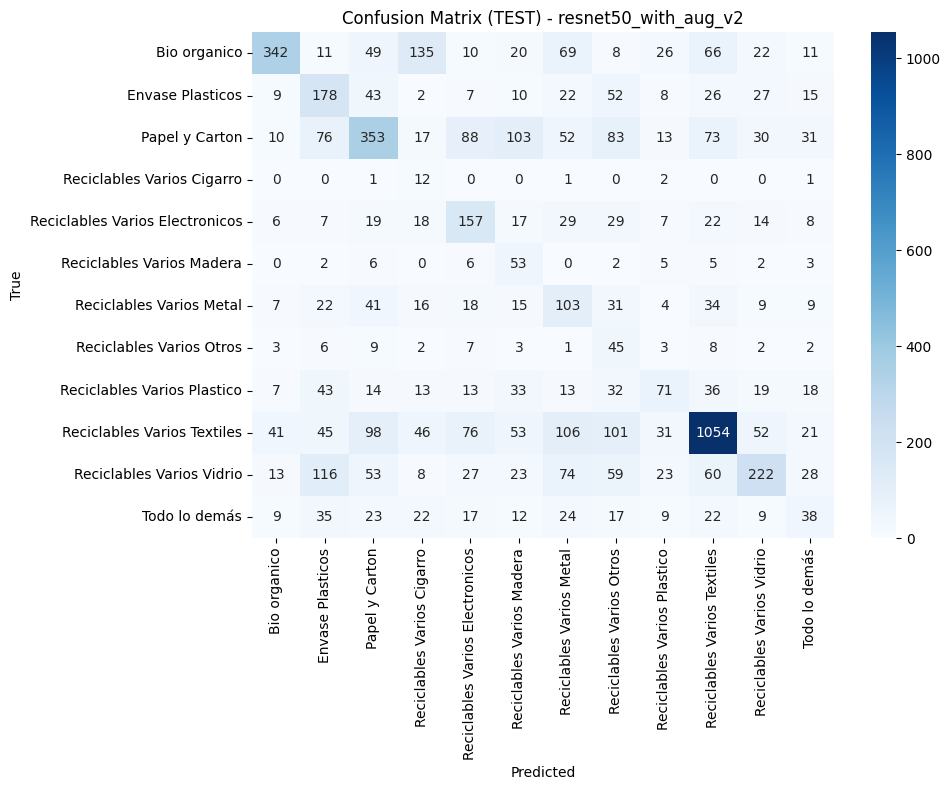

Confusion matrix figure saved to: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_with_aug_v2/resnet50_with_aug_v2_TEST_confusion_matrix.png


In [12]:
# ------------------------------------------
# Step 10 – Final evaluation (best fine-tuned model) on TEST SET
# ------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load best Phase 2 model if exists, else Phase 1
if os.path.exists(phase2_ckpt_path):
    print(f"[{EXP_NAME}] Loading final best model (Phase 2)...")
    model = tf.keras.models.load_model(phase2_ckpt_path)
elif os.path.exists(phase1_ckpt_path):
    print(f"[{EXP_NAME}] Phase 2 not found, using best Phase 1 model...")
    model = tf.keras.models.load_model(phase1_ckpt_path)
else:
    raise FileNotFoundError(
        f"No checkpoint found for evaluation in experiment '{EXP_NAME}'."
    )

# 1) Optional: validation performance (model selection set)
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"[{EXP_NAME}] Validation loss: {val_loss:.4f}")
print(f"[{EXP_NAME}] Validation accuracy: {val_acc:.4f}")

# 2) MAIN: TEST performance (unseen final evaluation)
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"[{EXP_NAME}] TEST loss: {test_loss:.4f}")
print(f"[{EXP_NAME}] TEST accuracy: {test_acc:.4f}")

# 3) Predictions on TEST set
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = [index_to_class[i] for i in range(num_classes)]

print("\nClassification Report (TEST):")
report_str = classification_report(y_true, y_pred, target_names=target_names)
print(report_str)

# 🔹 Save classification report to file for this experiment
report_path = os.path.join(EXP_DIR, f"{EXP_NAME}_TEST_classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Experiment: {EXP_NAME}\n")
    f.write(f"Validation loss: {val_loss:.4f}\n")
    f.write(f"Validation accuracy: {val_acc:.4f}\n\n")
    f.write(f"TEST loss: {test_loss:.4f}\n")
    f.write(f"TEST accuracy: {test_acc:.4f}\n\n")
    f.write(report_str)

print(f"\nTEST classification report saved to: {report_path}")

# 4) Confusion matrix on TEST set
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (TEST) - {EXP_NAME}")
plt.tight_layout()

cm_fig_path = os.path.join(EXP_DIR, f"{EXP_NAME}_TEST_confusion_matrix.png")
plt.savefig(cm_fig_path, dpi=150)
plt.show()

print(f"Confusion matrix figure saved to: {cm_fig_path}")


**View continuous charts based on hist logs to see how training evolved**

1. Read the history objects

```
history1.history and history2.history are dicts like:

{
  'loss': [...],
  'accuracy': [...],
  'val_loss': [...],
  'val_accuracy': [...]
}
```

The code checks if history1 exists (it might not, if we didn’t re-train Phase 1 in this run).

2. Create a continuous epoch axis

- If we have both phases:

  - Phase 1 might be epochs 1–5

  - Phase 2 becomes 6–25, etc.

- If only Phase 2: it just uses 1..N for Phase 2.

3. Plot line charts

- Chart 1: train vs val accuracy per epoch.

- Chart 2: train vs val loss per epoch.

In order to discuss potential:

- Overfitting (if val curves diverge from train).

- Effect of fine-tuning (often we see a jump in accuracy when Phase 2 starts).

- LR reductions (sometimes visible as “kinks” in the curve).

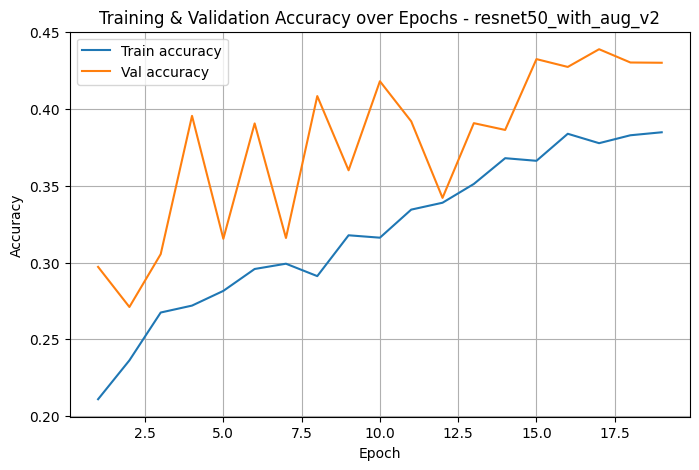

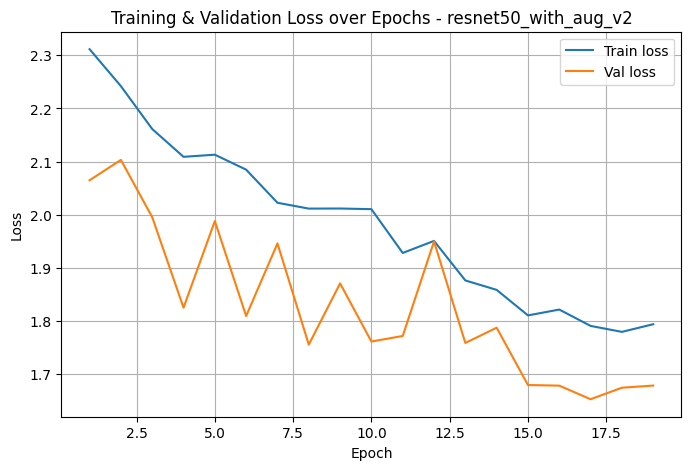

In [13]:
import matplotlib.pyplot as plt
import numpy as np

histories = []
phase_names = []

if 'history1' in globals() and history1 is not None:
    histories.append(history1.history)
    phase_names.append("Phase 1 (head)")

if 'history2' in globals() and history2 is not None:
    histories.append(history2.history)
    phase_names.append("Phase 2 (fine-tuning)")

all_epochs = []
all_acc = []
all_val_acc = []
all_loss = []
all_val_loss = []

epoch_offset = 0
for h, name in zip(histories, phase_names):
    n = len(h['loss'])
    epochs = np.arange(epoch_offset + 1, epoch_offset + n + 1)

    all_epochs.extend(epochs)
    all_acc.extend(h.get('accuracy', [np.nan] * n))
    all_val_acc.extend(h.get('val_accuracy', [np.nan] * n))
    all_loss.extend(h.get('loss', [np.nan] * n))
    all_val_loss.extend(h.get('val_loss', [np.nan] * n))

    epoch_offset += n

all_epochs = np.array(all_epochs)
all_acc = np.array(all_acc)
all_val_acc = np.array(all_val_acc)
all_loss = np.array(all_loss)
all_val_loss = np.array(all_val_loss)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(all_epochs, all_acc, label='Train accuracy')
plt.plot(all_epochs, all_val_acc, label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training & Validation Accuracy over Epochs - {EXP_NAME}')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(all_epochs, all_loss, label='Train loss')
plt.plot(all_epochs, all_val_loss, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training & Validation Loss over Epochs - {EXP_NAME}')
plt.legend()
plt.grid(True)
plt.show()


**View examples of images that were classified correctly VS images that were not classified correctly.**

1. We run the model on the entire test set

model.predict(test_gen) → prediction probabilities for each class.

np.argmax(..., axis=1) → predicted class index for each image.

y_true = test_gen.classes comes from the generator (sparse labels).

2. Separate correct and incorrect predictions

correct_idx → indices where y_pred == y_true.

incorrect_idx → where they differ.

3. Display image grids

- Use test_gen.filepaths (actual paths to images).

- For each sampled example, we see:

  - The actual image.

  - True: class_name

  - Pred: class_name (confidence)

  - Confidence = softmax probability for the predicted class.

[resnet50_with_aug_v2] Recomputed TEST accuracy (check): 0.4447
Correctly classified test images   : 2628
Incorrectly classified test images : 3282


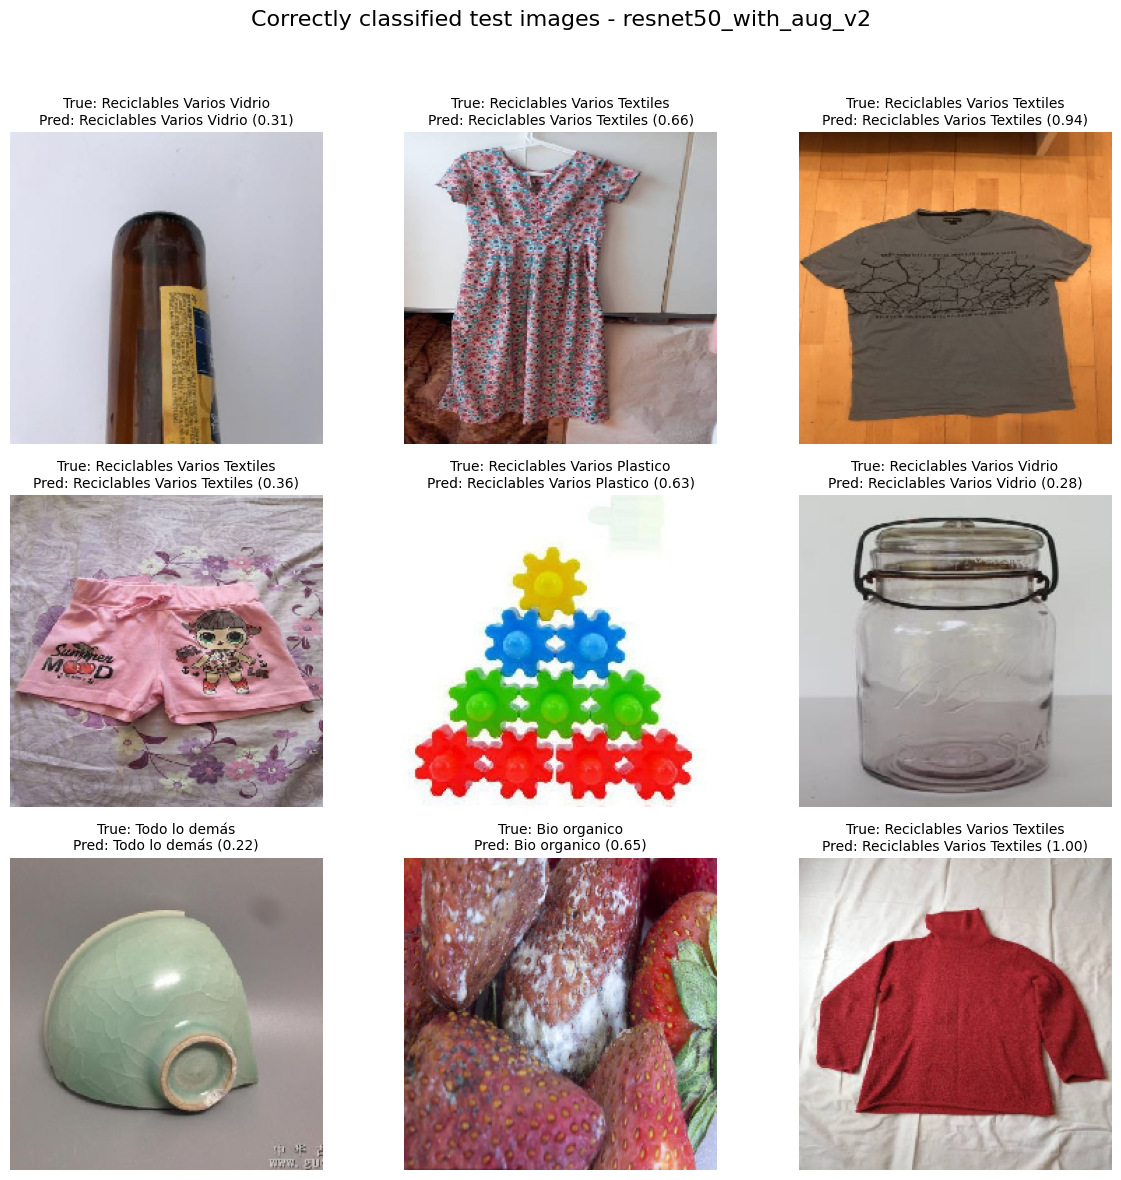

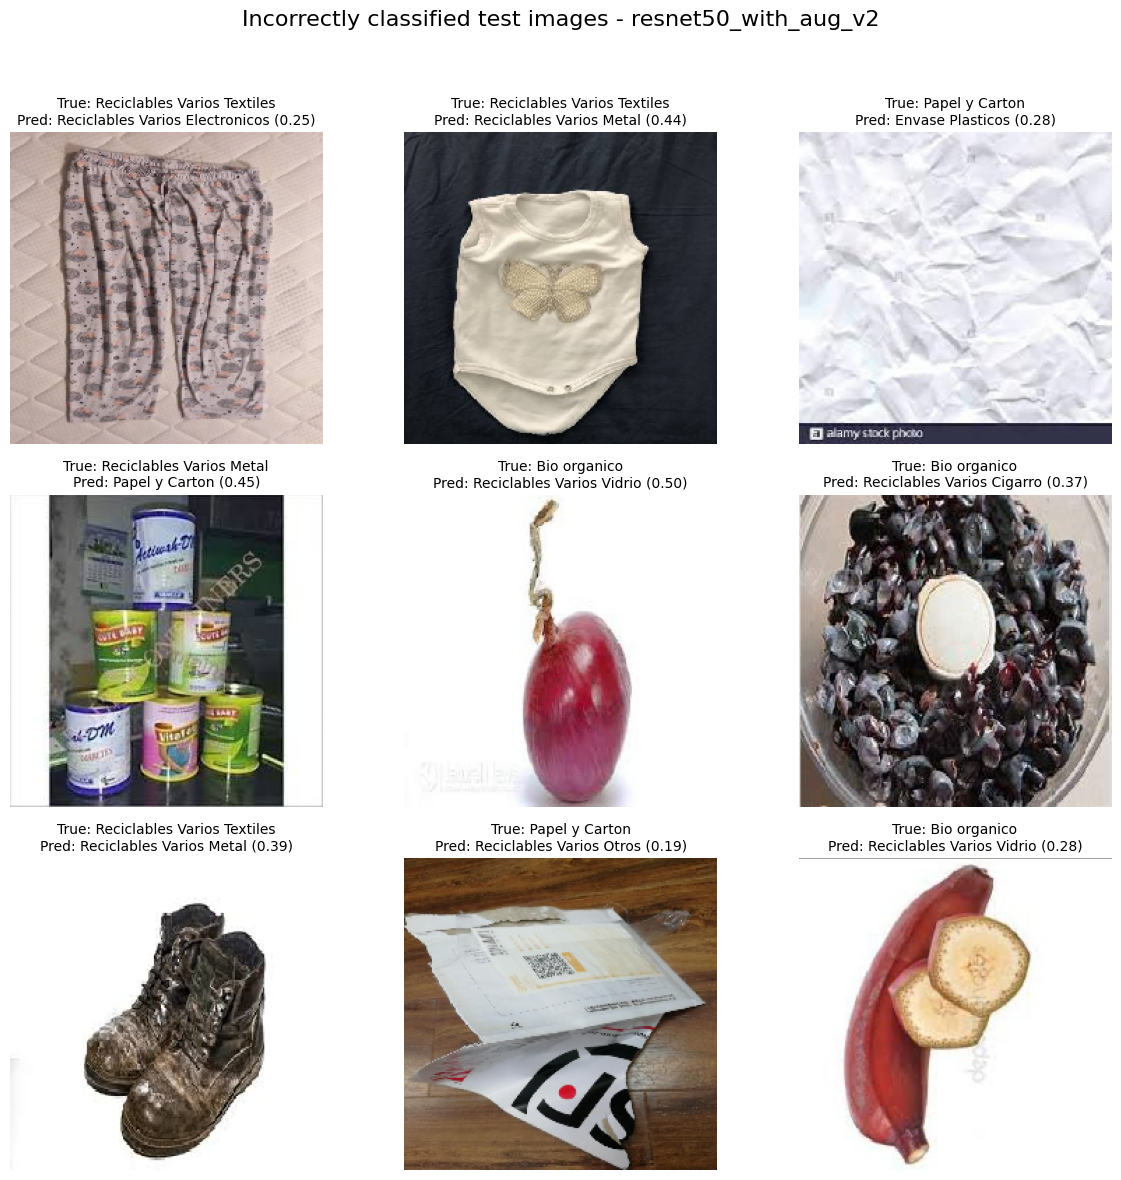

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ---------------------------------------------------
# Use predictions and labels already computed in Step 10
#   y_true        -> ground truth labels (from test_gen.classes)
#   y_pred        -> predicted labels (argmax of y_pred_probs)
#   y_pred_probs  -> prediction probabilities from model.predict(test_gen)
#   test_gen      -> your test generator
#   index_to_class -> int -> class name mapping from earlier
# ---------------------------------------------------

# Get filepaths from the test generator
filepaths = np.array(test_gen.filepaths)

# Just to have a shorter name
y_prob = y_pred_probs

# Sanity check: basic test accuracy (should match Step 10 print)
test_accuracy = np.mean(y_pred == y_true)
print(f"[{EXP_NAME}] Recomputed TEST accuracy (check): {test_accuracy:.4f}")

# ---------------------------------------------------
# 1) Find correct & incorrect indices
# ---------------------------------------------------
correct_idx = np.where(y_pred == y_true)[0]
incorrect_idx = np.where(y_pred != y_true)[0]

print(f"Correctly classified test images   : {len(correct_idx)}")
print(f"Incorrectly classified test images : {len(incorrect_idx)}")

# ---------------------------------------------------
# 2) Helper function to show a grid of images
# ---------------------------------------------------
def show_examples(indices, n=9, title="Examples", index_to_class=None):
    """
    indices: array of indices in the test set
    n: number of images to display
    index_to_class: dict int -> class name
    """
    if len(indices) == 0:
        print(f"No examples to show for: {title}")
        return

    n = min(n, len(indices))
    chosen = np.random.choice(indices, size=n, replace=False)

    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 4, rows * 4))
    plt.suptitle(title, fontsize=16)

    for i, idx in enumerate(chosen, start=1):
        img_path = filepaths[idx]
        true_label_idx = y_true[idx]
        pred_label_idx = y_pred[idx]
        probs = y_prob[idx]
        pred_conf = probs[pred_label_idx]

        true_label = index_to_class.get(true_label_idx, str(true_label_idx)) if index_to_class else str(true_label_idx)
        pred_label = index_to_class.get(pred_label_idx, str(pred_label_idx)) if index_to_class else str(pred_label_idx)

        img = image.load_img(img_path, target_size=(224, 224))
        img_arr = image.img_to_array(img) / 255.0

        plt.subplot(rows, cols, i)
        plt.imshow(img_arr)
        plt.axis('off')
        plt.title(
            f"True: {true_label}\nPred: {pred_label} ({pred_conf:.2f})",
            fontsize=10
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ---------------------------------------------------
# 3) Show some CORRECT predictions
# ---------------------------------------------------
show_examples(
    correct_idx,
    n=9,
    title=f"Correctly classified test images - {EXP_NAME}",
    index_to_class=index_to_class
)

# ---------------------------------------------------
# 4) Show some INCORRECT predictions
# ---------------------------------------------------
show_examples(
    incorrect_idx,
    n=9,
    title=f"Incorrectly classified test images - {EXP_NAME}",
    index_to_class=index_to_class
)


### Step 11 – Prediction function for new images

This lets you classify new images using the trained model.


[resnet50_with_aug_v2] Loading best Phase 2 model for predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

[resnet50_with_aug_v2] Predictions for: /content/drive/MyDrive/Colab Notebooks/ComputerVision/new_test_images/test_image.jpeg
  Todo lo demás: 0.2325
  Reciclables Varios Madera: 0.1675
  Reciclables Varios Textiles: 0.1438


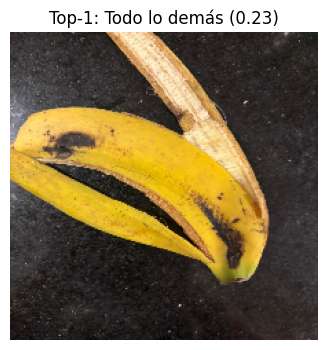

In [19]:
# ------------------------------------------
# Step 11 – Prediction function for new images
# ------------------------------------------
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt

def preprocess_single_image(image_path, target_size=IMG_SIZE):
    """
    Loads and preprocesses a single image for prediction.
    Handles truncated images safely.
    """
    img = load_img(image_path, target_size=target_size)
    arr = img_to_array(img).astype("float32") / 255.0
    return arr

def load_best_experiment_model():
    """
    Loads the best model available for THIS experiment:
    1. Phase 2 (fine-tuned) model, if exists
    2. Otherwise Phase 1 model
    """
    if os.path.exists(phase2_ckpt_path):
        print(f"[{EXP_NAME}] Loading best Phase 2 model for predictions...")
        return tf.keras.models.load_model(phase2_ckpt_path)

    if os.path.exists(phase1_ckpt_path):
        print(f"[{EXP_NAME}] Loading best Phase 1 model for predictions...")
        return tf.keras.models.load_model(phase1_ckpt_path)

    raise FileNotFoundError(
        f"No trained model found for experiment '{EXP_NAME}'. "
        "Train Phase 1 or Phase 2 first."
    )

def predict_image(image_path, model=None, top_k=3, save_result=False):
    """
    Predicts top-K classes for a given image.
    If no model is provided, loads the best model for this experiment.
    """
    # Auto-load model if needed
    if model is None:
        model = load_best_experiment_model()

    # Preprocess
    arr = preprocess_single_image(image_path)
    arr_batch = np.expand_dims(arr, axis=0)

    # Predict
    preds = model.predict(arr_batch)[0]
    top_indices = np.argsort(preds)[::-1][:top_k]
    top_probs = preds[top_indices]
    top_labels = [index_to_class[i] for i in top_indices]

    # Display
    print(f"\n[{EXP_NAME}] Predictions for: {image_path}")
    for lbl, prob in zip(top_labels, top_probs):
        print(f"  {lbl}: {prob:.4f}")

    # Show image with Top-1 class
    plt.figure(figsize=(4, 4))
    plt.imshow(arr)
    plt.axis('off')
    plt.title(f"Top-1: {top_labels[0]} ({top_probs[0]:.2f})")
    plt.show()

    # Optionally save prediction results
    if save_result:
        pred_path = os.path.join(EXP_DIR, f"{EXP_NAME}_prediction.txt")
        with open(pred_path, "w") as f:
            f.write(f"Experiment: {EXP_NAME}\n")
            f.write(f"Image: {image_path}\n\n")
            for lbl, prob in zip(top_labels, top_probs):
                f.write(f"{lbl}: {prob:.4f}\n")

        print(f"Prediction saved to: {pred_path}")

# Example usage (AFTER training):
predict_image('/content/drive/MyDrive/Colab Notebooks/ComputerVision/new_test_images/test_image.jpeg')


“We use ImageDataGenerator to perform online augmentation, so each epoch the model sees different random variations (flip, rotation, zoom, brightness).”

“Only the training generator uses augmentation; the validation generator only rescales images, so validation metrics are measured on clean data.”

“We train ResNet50 in two phases: first only the classifier head on frozen ImageNet features, then we fine-tune the top layers of the backbone with a smaller learning rate.”

“Class weights are computed from the training distribution so that underrepresented waste categories are not ignored.”

**Online Data Augmentation and ResNet-50 Training**
1. Overview

To improve the robustness and generalization ability of our waste-classification models, we implemented an online data augmentation pipeline combined with a two-phase transfer learning strategy using ResNet-50 pretrained on ImageNet. Unlike offline augmentation—which physically generates and stores augmented images—online augmentation applies transformations dynamically during training. This approach significantly reduces preprocessing time, avoids storage overhead, and provides fresh variations at every epoch, improving model generalization across diverse waste image scenarios.

2. Online Data Augmentation Strategy

We applied data augmentation using ImageDataGenerator, a standard Keras utility for real-time image transformation. The training generator performs augmentations directly in RAM before feeding each batch to the model, ensuring that each epoch sees slightly different variations of the same images. This creates an effectively infinite training dataset without need for additional storage.

The augmentations were chosen to reflect realistic variations in how users capture waste images:

- Horizontal Flip: accounts for mirroring due to camera orientation.

- Rotation (±15 degrees): simulates tilted camera angles.

- Zoom (±20%): handles variation in object distance and frame tightness.

- Brightness Perturbation: accounts for diverse illumination conditions.

The validation generator applies only rescaling, ensuring that model evaluation is performed on clean, unaltered images that reflect real performance. This separation of training augmentation and validation integrity is crucial for accurate performance assessment.

3. ResNet-50 Transfer Learning Workflow

We trained ResNet-50 using a two-phase transfer learning approach, which is standard for deep models on domain-specific datasets:

Phase 1 – Train the Classification Head

In the first stage, the convolutional base (i.e., the pretrained ResNet-50 feature extractor) is frozen. Only the newly added dense classification layer is trained. During this phase, ResNet-50 acts as a fixed feature extractor, and the classifier learns to map extracted features to our waste categories. This yields fast, stable convergence and prevents destructive updates to pretrained ImageNet features.

Phase 2 – Fine-Tune Upper Layers of ResNet-50

Once the classifier stabilizes, we unfreeze the top ~30 layers of the ResNet-50 backbone and train them with a much smaller learning rate. These higher layers encode semantic features (object shapes, textures, patterns) that are more adaptable to the waste-classification domain. Lower layers, which capture edges and color contrasts, remain frozen to preserve their general utility.
Fine-tuning enhances model specialization while reducing risk of overfitting or catastrophic forgetting.

4. Handling Class Imbalance

Our dataset exhibits class imbalance across waste categories. To mitigate bias toward majority classes, we computed class weights proportional to the inverse frequency of each class and passed them to the training process. This adjustment penalizes errors on minority classes more strongly, forcing the model to learn balanced representations.

5. Evaluation Protocol

Model performance was evaluated on the clean validation set (no augmentation) to ensure that results represent real-world classifiers rather than augmented distortions. We report:

Overall accuracy

Per-class precision, recall, and F1-score (classification report)

Confusion matrix to analyze misclassification patterns

This multi-metric evaluation provides a comprehensive understanding of model behavior and highlights categories that may require additional dataset balancing or domain-specific augmentation.

6. Prediction Function for Real-World Use

We implemented a prediction utility that accepts a new image, preprocesses it using the same normalization pipeline as the training generators, and outputs the top predicted waste categories with probabilities. This function supports the integration of the trained model into an application or sorting interface.